In [67]:
%reset -f

In [68]:
import os
import psycopg2
from dotenv import load_dotenv # add this line

# load variables from .env file
load_dotenv()

host = os.getenv('PGSQL_HOST')
port = os.getenv('PGSQL_PORT')
database = os.getenv('PGSQL_DB')
user = os.getenv('PGSQL_USER')
password = os.getenv('PGSQL_PASS')

# connecting to the database
connection = psycopg2.connect(database=database, user=user, password=password, port=port, host=host)

# instantiating the cursor
cursor = connection.cursor()

In [69]:
# Quick connection check
cursor.execute("SELECT version();")
record = cursor.fetchone()
print("You are connected to - ", record, "\n")

You are connected to -  ('PostgreSQL 11.9 (Raspbian 11.9-0+deb10u1) on arm-unknown-linux-gnueabihf, compiled by gcc (Raspbian 8.3.0-6+rpi1) 8.3.0, 32-bit',) 



In [70]:
import datetime

# Change below depending on your situation
start_analysis = datetime.datetime(2020, 2, 1)
end_analysis = datetime.datetime.now()

query = """
SELECT read_at, 
delivered_1+delivered_2 as delivered, 
returned_1+returned_2 as returned 
FROM public.dsmr_consumption_electricityconsumption 
WHERE read_at>%s AND read_at<%s
ORdER BY read_at ASC;
"""
params = [start_analysis, end_analysis]

In [71]:
import pandas as pd
import pandas.io.sql as sqlio

df = sqlio.read_sql_query(sql=query, con=connection, params=params)
connection = None

In [72]:
#calculate totals
delivered_during_timeframe = df['delivered'].iloc[-1]-df['delivered'].iloc[0]
returned_during_timeframe = df['returned'].iloc[-1]-df['returned'].iloc[0]
delivered_during_timeframe,returned_during_timeframe

(3560.6560000000004, 5409.523)

In [73]:
class Accumulator:
	def __init__(self,columnlist=None,columndict=None,autoaddcolumn=True):
		from collections import OrderedDict
		self.appenddict=OrderedDict()
		self.columnlist=columnlist
		if columnlist is not None:
			for column in columnlist:
				self.appenddict[column]=[]
		self.columndict=columndict
		self.autoaddcolumn=autoaddcolumn
	def append_value(self,column,value):
		try:
			self.appenddict[column].append(value)
		except KeyError as ex:
			if self.autoaddcolumn:
				self.appenddict[column]=[value]
			else:
				raise ex
	def append_row(self,dataframerow):
		for column in self.columnlist:
			self.append_value(column,dataframerow[column])
	def map_row(self,dataframerow):
		for targetcol,sourcecol in self.columndict.items():
			if sourcecol[0:2]=='c:':
				self.append_value(targetcol,sourcecol[2:])
			else:
				self.append_value(targetcol,dataframerow[sourcecol])
	def getdataframe(self):
		import pandas as pd
		result=pd.DataFrame()
		for column,value in self.appenddict.items():
			result[column]=value
		return result
	def getdict(self,key):
		result={}
		key_column=self.appenddict[key]
		i=0
		for key_value in key_column:
			temp_dict={}
			for column,value in self.appenddict.items():
				if column != key:
					temp_dict[column]=value[i]
			result[key_value]=temp_dict
			i+=1
		return result

In [74]:
from datetime import datetime
print(datetime.now())
accumulator=Accumulator(df.columns)
delivered_prev=df._get_value(0,'delivered')
returned_prev=df._get_value(0,'returned')
for row in df.itertuples():
    row=row._asdict()
    accumulator.append_row(row)
    accumulator.append_value('currently_delivered',row['delivered']-delivered_prev)
    accumulator.append_value('currently_returned',row['returned']-returned_prev)
    delivered_prev=row['delivered']
    returned_prev=row['returned']
df=accumulator.getdataframe()
print(datetime.now())

2021-01-29 22:43:34.713153
2021-01-29 22:43:37.820599


In [75]:
# set battery efficiencies
charging_eff = 0.95
discharging_eff = 0.95

In [76]:
import numpy as np

def calculate_battery_effect(dfx, size_kwh, c_eff, d_eff):
    accumulator=Accumulator(dfx.columns)
    
    # battery_state = kWh energy supply it holds
    # delivered_with_battery = new "total delivered from grid" with the addition of a battery
    # returned_with_battery = new "total returned to grid" with the addition of a battery
    battery_state_prev=0
    delivered_with_battery_prev=0
    returned_with_battery_prev=0
    
    for row in dfx.itertuples():
        row=row._asdict()
        battery_state = np.maximum(0,np.minimum(size_kwh, battery_state_prev + c_eff*row['currently_returned'] - row['currently_delivered']/d_eff))
        delivered_with_battery = delivered_with_battery_prev + row['currently_delivered'] - d_eff*np.maximum(battery_state_prev-battery_state,0)
        returned_with_battery = returned_with_battery_prev + row['currently_returned'] - c_eff*np.maximum(battery_state-battery_state_prev,0)
        
        accumulator.append_row(row)
        accumulator.append_value('battery_state',battery_state)
        accumulator.append_value('delivered_with_battery',delivered_with_battery)
        accumulator.append_value('returned_with_battery',returned_with_battery)
        
        battery_state_prev=battery_state
        delivered_with_battery_prev=delivered_with_battery
        returned_with_battery_prev=returned_with_battery
        
    dfx=accumulator.getdataframe()
        
    return dfx[['battery_state','delivered_with_battery','returned_with_battery']]

In [77]:
print(datetime.now())
from joblib import Parallel, delayed
import multiprocessing

battery_sizes = [1,2,3,4,5,6,8,10,15,20,30]
 
num_cores = multiprocessing.cpu_count()

results = Parallel(n_jobs=num_cores)(delayed(calculate_battery_effect)(df,i,charging_eff,discharging_eff) for i in battery_sizes)
print(datetime.now())

2021-01-29 22:43:37.868689
2021-01-29 22:44:20.916183


In [78]:
for i in range(0, len(results)):
    size = battery_sizes[i]
    df[f'{size}kwh_battery_state'] = results[i]['battery_state']
    df[f'delivered_with_{size}kwh_battery'] = results[i]['delivered_with_battery']
    df[f'returned_with_{size}kwh_battery'] = results[i]['returned_with_battery']

results = None

In [79]:
summary = None
summary = pd.DataFrame ({ 'battery_size_kwh' : battery_sizes})
summary['delivered'] = 0
summary['returned'] = 0

for i in range(0, len(summary)):
    size = summary['battery_size_kwh'].iloc[i]
    summary['delivered'][i] = df[f'delivered_with_{size}kwh_battery'].iloc[-1]-df[f'delivered_with_{size}kwh_battery'].iloc[0]
    summary['returned'][i] = df[f'returned_with_{size}kwh_battery'].iloc[-1]-df[f'returned_with_{size}kwh_battery'].iloc[0]

summary.index = summary.index + 1
summary.loc[0] = [0, delivered_during_timeframe, returned_during_timeframe]
summary = summary.sort_index()

summary

battery_size_kwh  delivered  returned
0                0.0   3560.656  5409.523
1                1.0   3134.000  4983.000
2                2.0   2844.000  4693.000
3                3.0   2572.000  4421.000
4                4.0   2313.000  4162.000
5                5.0   2067.000  3916.000
6                6.0   1848.000  3697.000
7                8.0   1560.000  3409.000
8               10.0   1416.000  3264.000
9               15.0   1289.000  3138.000
10              20.0   1243.000  3092.000
11              30.0   1201.000  3050.000

<AxesSubplot:xlabel='battery size [kWh]', ylabel='energy [kWh]'>

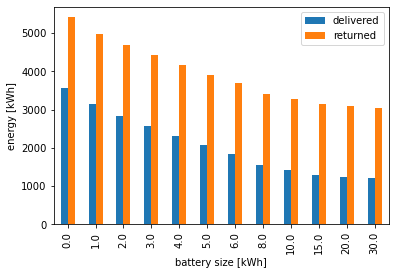

In [80]:
summary.plot(x='battery_size_kwh', kind="bar", xlabel="battery size [kWh]", ylabel="energy [kWh]")

(0.0, 893.3940171000002)

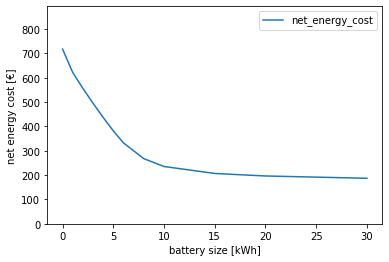

In [81]:
# Change below depending on your situation
cost_delivered_energy = 0.27
gain_returned_energy = 0.045

summary['net_energy_cost'] = summary['delivered'] * cost_delivered_energy - summary['returned'] * gain_returned_energy
ax = summary.plot(x='battery_size_kwh', y='net_energy_cost', kind="line", xlabel="battery size [kWh]", ylabel="net energy cost [€]")
yabs_max = abs(max(ax.get_ylim(), key=abs))*1.2
ax.set_ylim(ymin=0, ymax=yabs_max)

<AxesSubplot:xlabel='battery size [kWh]', ylabel='energy cost reduction [€]'>

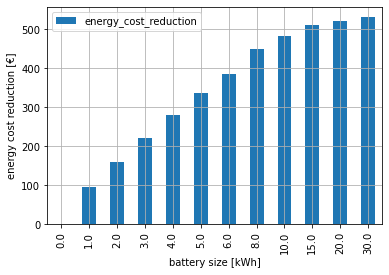

In [88]:
summary['energy_cost_reduction'] = summary._get_value(0,'net_energy_cost') - summary['net_energy_cost']
summary.plot(x='battery_size_kwh', y='energy_cost_reduction', kind="bar", xlabel="battery size [kWh]", ylabel="energy cost reduction [€]", grid=True)